# TIME EVOLUTION OF THE EFT COUNTER-TERMS

In [1]:
import numpy as np
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')

## Quijote simulations

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.11, Ob0=0.049, Om0= 0.2685)

* Best fit values from the Quijote simulation

In [3]:
z = np.array([0,0.5,1,2,3])
c2 = np.array([2.629, 0.977, 0.392, 0.100, 0.000])

c2upper = np.array([0.008, 0.004, 0.002, 0.001, 0.000])
c2lower = np.array([0.008, 0.004, 0.002, 0.001, 0.002])
var = c2lower * c2lower
err = np.array([c2lower,c2upper])

* Interpolation

In [4]:
z_int = np.array([0,0.5,1,2,3, 10, 1100])
c2_int = np.array([2.629, 0.977, 0.392, 0.100, 0.000, 0.0, 0.0])
c2_interpolate = interp1d(z_int, c2_int, kind='cubic')

z_vector = np.linspace(0,3,num=1000)
c2_int = c2_interpolate(z_vector)

## C2 model

* Counter-term evolution parametrisation

In [5]:
def c2model(redshift,theta):
    m, n, a = theta
    return  m * np.exp(-a * redshift)  + n

* Best fit

In [6]:
def log_likelihood(theta, data, covariance):
    
    m, n, a = theta 
    model = c2model(z, theta)
    
    X = data - model
    C = covariance
    X_C = X/C
        
    return -0.5 * np.dot(X, X /C) 

In [46]:
from scipy.optimize import minimize

theta_true = np.array([2.5, 0, 2])


nll = lambda *args: -log_likelihood(*args)
initial = theta_true
soln = minimize(nll, initial, args=(c2, var))
p_ml = soln.x

print("Maximum likelihood estimates:")
print(p_ml)

Maximum likelihood estimates:
[2.56435053 0.0362764  1.96132732]


* Likelihood analysis

In [47]:
def log_prior(theta):
    return 1/theta 

In [48]:
def log_probability(theta, data, covariance):
    return log_prior(theta) + log_likelihood(theta, data, covariance)

In [49]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(500, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(c2, var))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [01:20<00:00, 124.94it/s]


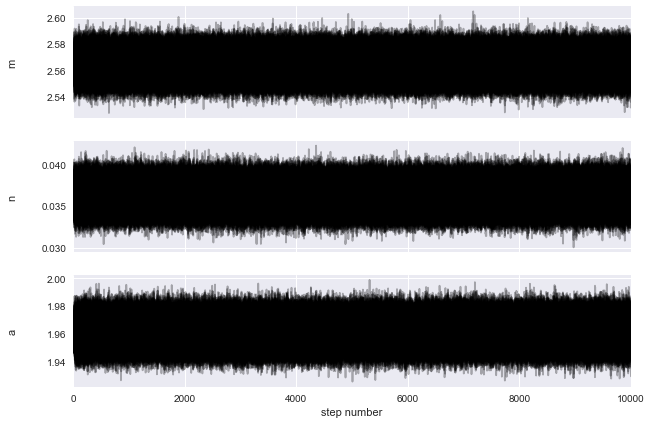

In [50]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "n", "a"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [51]:
tau = sampler.get_autocorr_time()
print(tau);

[38.0776538  37.43854743 36.91887289]


In [52]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(330000, 3)


In [53]:
from IPython.display import display, Math
best_fit = np.empty(3)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    best_fit[i] = mcmc[1]
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

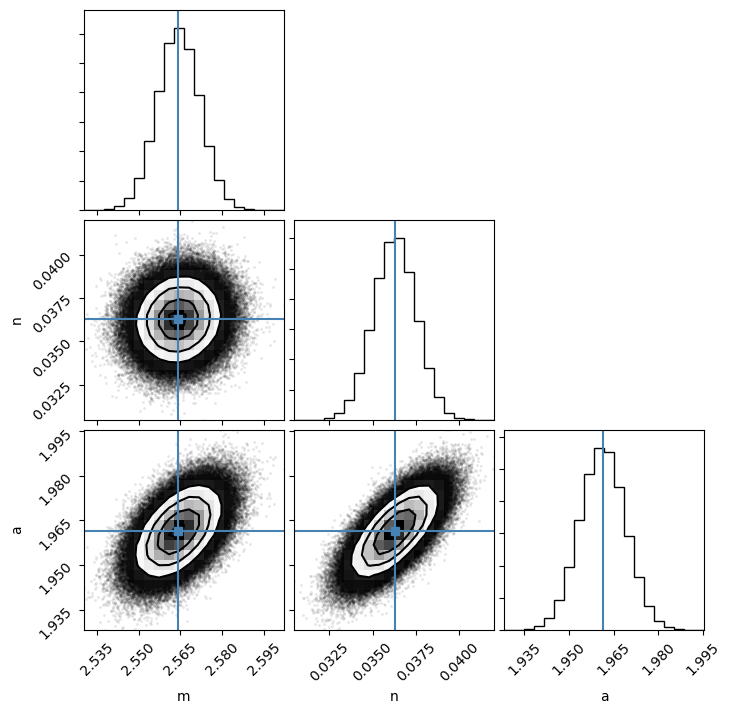

In [83]:
import corner
m_true, n_true, a_true = best_fit 
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, n_true, a_true]);

In [65]:
c2_best = c2model(z_vector,best_fit)

### Plot

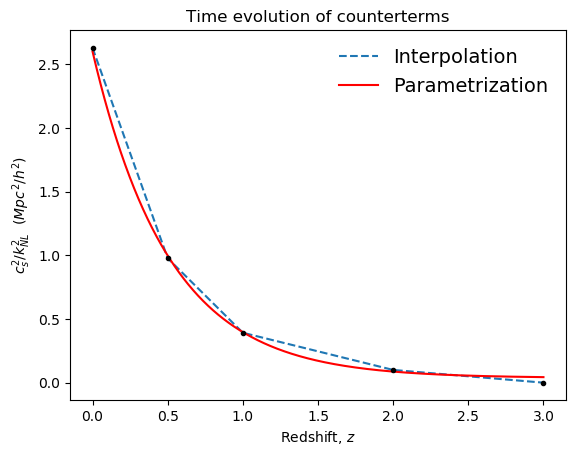

In [77]:
plt.plot(z, c2, '--', label='Interpolation')
plt.plot(z_vector, c2_best, 'r', label='Parametrization')
plt.errorbar(z, c2, yerr=err, fmt='.k', capsize=0)

plt.title('Time evolution of counterterms')
plt.xlabel('Redshift, $z$')
plt.ylabel('$ c^2_{s}/k_{NL}^2$  $(Mpc^2/h^2)$')
plt.legend(fontsize=14, frameon=False);